![MLU Logo](../data/MLU_Logo.png)

# <a name="0">Machine Learning Accelerator - Tabular Data - Lecture 1</a>


## K Nearest Neighbors Model 

In this notebook, we build a [__K Nearest Neighbors Classifier__](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) to predict the __Outcome Type__ field of our review dataset.

1. <a href="#1">Read the dataset</a>
2. <a href="#2">Exploratory Data Analysis</a>
3. <a href="#3">Select features to build the model</a>
4. <a href="#4">Training and test datasets</a>
5. <a href="#5">Data processing with Pipeline</a>
6. <a href="#6">Train a classifier</a>
7. <a href="#7">Test the classifier</a>
8. <a href="#8">Improvement ideas</a>

__Austin Animal Center Dataset__:

In this exercise, we are working with pet adoption data from __Austin Animal Center__. We have two datasets that cover intake and outcome of animals. Intake data is available from [here](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Intakes/wter-evkm) and outcome is from [here](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Outcomes/9t4d-g238). 

In order to work with a single table, we joined the intake and outcome tables using the "Animal ID" column and created a single __review.csv__ file. We also didn't consider animals with multiple entries to the facility to keep our dataset simple. If you want to see the original datasets and the merged data with multiple entries, they are available under data/review folder: Austin_Animal_Center_Intakes.csv, Austin_Animal_Center_Outcomes.csv and Austin_Animal_Center_Intakes_Outcomes.csv.

__Dataset schema:__ 
- __Pet ID__ - Unique ID of pet
- __Outcome Type__ - State of pet at the time of recording the outcome (0 = not placed, 1 = placed). This is the field to predict.
- __Sex upon Outcome__ - Sex of pet at outcome
- __Name__ - Name of pet 
- __Found Location__ - Found location of pet before entered the center
- __Intake Type__ - Circumstances bringing the pet to the center
- __Intake Condition__ - Health condition of pet when entered the center
- __Pet Type__ - Type of pet
- __Sex upon Intake__ - Sex of pet when entered the center
- __Breed__ - Breed of pet 
- __Color__ - Color of pet 
- __Age upon Intake Days__ - Age of pet when entered the center (days)
- __Age upon Outcome Days__ - Age of pet at outcome (days)


In [1]:
%pip install -q -r ../requirements.txt

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p39/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## 1. <a name="1">Read the dataset</a>
(<a href="#0">Go to top</a>)

Let's read the dataset into a dataframe, using Pandas.

In [2]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")
  
df = pd.read_csv('../data/review/review_dataset.csv')

print('The shape of the dataset is:', df.shape)

The shape of the dataset is: (95485, 13)


## 2. <a name="2">Exploratory Data Analysis</a>
(<a href="#0">Go to top</a>)

We will look at number of rows, columns and some simple statistics of the dataset.

In [3]:
# Print the first five rows
# NaN means missing data
df.head()

,Pet ID,Outcome Type,Sex upon Outcome,Name,Found Location,Intake Type,Intake Condition,Pet Type,Sex upon Intake,Breed,Color,Age upon Intake Days,Age upon Outcome Days
0,A794011,1.0,Neutered Male,Chunk,Austin (TX),Owner Surrender,Normal,Cat,Neutered Male,Domestic Shorthair Mix,Brown Tabby/White,730,730
1,A776359,1.0,Neutered Male,Gizmo,7201 Levander Loop in Austin (TX),Stray,Normal,Dog,Intact Male,Chihuahua Shorthair Mix,White/Brown,365,365
2,A674754,0.0,Intact Male,NaN,12034 Research in Austin (TX),Stray,Nursing,Cat,Intact Male,Domestic Shorthair Mix,Orange Tabby,6,6
3,A689724,1.0,Neutered Male,*Donatello,2300 Waterway Bnd in Austin (TX),Stray,Normal,Cat,Intact Male,Domestic Shorthair Mix,Black,60,60
4,A680969,1.0,Neutered Male,*Zeus,4701 Staggerbrush Rd in Austin (TX),Stray,Nursing,Cat,Intact Male,Domestic Shorthair Mix,White/Orange Tabby,7,60


In [4]:
# Let's see the data types and non-null values for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95485 entries, 0 to 95484
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Pet ID                 95485 non-null  object 
 1   Outcome Type           95485 non-null  float64
 2   Sex upon Outcome       95484 non-null  object 
 3   Name                   59138 non-null  object 
 4   Found Location         95485 non-null  object 
 5   Intake Type            95485 non-null  object 
 6   Intake Condition       95485 non-null  object 
 7   Pet Type               95485 non-null  object 
 8   Sex upon Intake        95484 non-null  object 
 9   Breed                  95485 non-null  object 
 10  Color                  95485 non-null  object 
 11  Age upon Intake Days   95485 non-null  int64  
 12  Age upon Outcome Days  95485 non-null  int64  
dtypes: float64(1), int64(2), object(10)
memory usage: 9.5+ MB


In [5]:
# This prints basic statistics for numerical columns
df.describe()

,Outcome Type,Age upon Intake Days,Age upon Outcome Days
count,95485.000000,95485.000000,95485.000000
mean,0.564005,703.436959,717.757313
std,0.495889,1052.252197,1055.023160
min,0.000000,0.000000,0.000000
25%,0.000000,30.000000,60.000000
50%,1.000000,365.000000,365.000000
75%,1.000000,730.000000,730.000000
max,1.000000,9125.000000,9125.000000


Let's separate model features and model target. 

In [6]:
print(df.columns)

Index(['Pet ID', 'Outcome Type', 'Sex upon Outcome', 'Name', 'Found Location',
       'Intake Type', 'Intake Condition', 'Pet Type', 'Sex upon Intake',
       'Breed', 'Color', 'Age upon Intake Days', 'Age upon Outcome Days'],
      dtype='object')


In [7]:
model_features = df.columns.drop('Outcome Type')
model_target = 'Outcome Type'

print('Model features: ', model_features)
print('Model target: ', model_target)

Model features:  Index(['Pet ID', 'Sex upon Outcome', 'Name', 'Found Location', 'Intake Type',
       'Intake Condition', 'Pet Type', 'Sex upon Intake', 'Breed', 'Color',
       'Age upon Intake Days', 'Age upon Outcome Days'],
      dtype='object')
Model target:  Outcome Type


We can explore the features set further, figuring out first what features are numerical or categorical. Beware that some integer-valued features could actually be categorical features, and some categorical features could be text features. 

In [8]:
import numpy as np
numerical_features_all = df[model_features].select_dtypes(include=np.number).columns
print('Numerical columns:',numerical_features_all)

print('')

categorical_features_all = df[model_features].select_dtypes(include='object').columns
print('Categorical columns:',categorical_features_all)


Numerical columns: Index(['Age upon Intake Days', 'Age upon Outcome Days'], dtype='object')

Categorical columns: Index(['Pet ID', 'Sex upon Outcome', 'Name', 'Found Location', 'Intake Type',
       'Intake Condition', 'Pet Type', 'Sex upon Intake', 'Breed', 'Color'],
      dtype='object')


#### Target distribution

Let's check our target distribution.

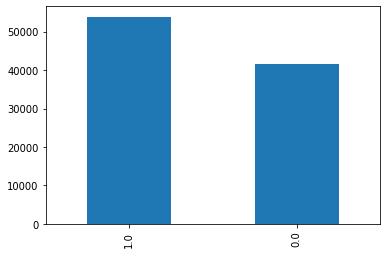

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

df[model_target].value_counts().plot.bar()
plt.show()

From the target plots we can identify whether or not we are dealing with imbalanced datasets - this means one result type is dominating the other one(s). 

Handling class imbalance is highly recommended, as the model performance can be greatly impacted. In particular the model may not work well for the infrequent classes, as there are not enough samples to learn patterns from, and so it would be hard for the classifier to identify and match those patterns. 

We might want to downsample the dominant class or upsample the rare the class, to help with learning its patterns. However, we should only fix the imbalance in training set, without changing the validation and test sets, as these should follow the original distribution. We will perform this task after train/test split. 


## 3. <a name="3">Select features to build the model</a>
(<a href="#0">Go to top</a>)

We only consider the __numerical features__ to build the model for this first sample solution. 

Let's examine the numerical features.

Age upon Intake Days


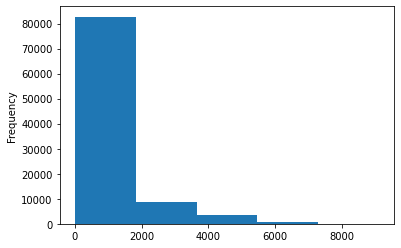

Age upon Outcome Days


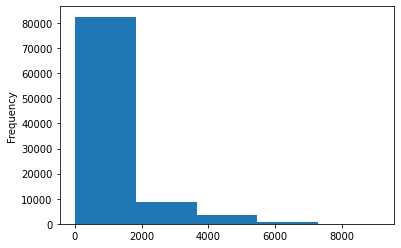

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

for c in numerical_features_all:
    print(c)
    df[c].plot.hist(bins=5)
    plt.show()

If for some histograms the values are heavily placed in the first bin, it is good to check for outliers, either checking the min-max values of those particular features and/or explore value ranges.

In [11]:
for c in numerical_features_all:
    print(c)
    print('min:', df[c].min(), 'max:', df[c].max())

Age upon Intake Days
min: 0 max: 9125
Age upon Outcome Days
min: 0 max: 9125


With __value_counts()__ function, we can increase the number of histogram bins to 10 for more bins for a more refined view of the numerical features.

In [12]:
for c in numerical_features_all: 
    print(c)
    print(df[c].value_counts(bins=10, sort=False))
    plt.show()

Age upon Intake Days
(-9.126, 912.5]     74835
(912.5, 1825.0]     10647
(1825.0, 2737.5]     3471
(2737.5, 3650.0]     3998
(3650.0, 4562.5]     1234
(4562.5, 5475.0]     1031
(5475.0, 6387.5]      183
(6387.5, 7300.0]       79
(7300.0, 8212.5]        5
(8212.5, 9125.0]        2
Name: Age upon Intake Days, dtype: int64
Age upon Outcome Days
(-9.126, 912.5]     74642
(912.5, 1825.0]     10699
(1825.0, 2737.5]     3465
(2737.5, 3650.0]     4080
(3650.0, 4562.5]     1263
(4562.5, 5475.0]     1061
(5475.0, 6387.5]      187
(6387.5, 7300.0]       81
(7300.0, 8212.5]        5
(8212.5, 9125.0]        2
Name: Age upon Outcome Days, dtype: int64


If any outliers are identified as very likely wrong values, dropping them could improve the numerical values histograms, and later overall model performance. While a good rule of thumb is that anything not in the range of (Q1 - 1.5 IQR) and (Q3 + 1.5 IQR) is an outlier, other rules for removing 'outliers' should be considered as well. 

Let's check missing values for these numerical features.

In [13]:
print(df[numerical_features_all].isna().sum())

Age upon Intake Days     0
Age upon Outcome Days    0
dtype: int64


If any missing values, as a quick fix, we can apply mean imputation. This will replace the missing values with the mean value of the corresponding column.

__Note__: The statistically correct way to perform mean/mode imputation before training an ML model is to compute the column-wise means on the training data only, and then use these values to impute missing data in both the train and test sets. So, you'll need to split your dataset first.

Also, more exploratory data analysis might reveal other important hidden atributes and/or relationships of the model features considered. 

## 4. <a name="4">Training and test datasets</a>
(<a href="#0">Go to top</a>)

We split our dataset into training (90%) and test (10%) subsets using sklearn's [__train_test_split()__](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function.

In [14]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, test_size=0.1, shuffle=True, random_state=23)

#### Target balancing

In [15]:
print('Training set shape:', train_data.shape)

print('Class 0 samples in the training set:', sum(train_data[model_target] == 0))
print('Class 1 samples in the training set:', sum(train_data[model_target] == 1))

print('Class 0 samples in the test set:', sum(test_data[model_target] == 0))
print('Class 1 samples in the test set:', sum(test_data[model_target] == 1))

Training set shape: (85936, 13)
Class 0 samples in the training set: 37499
Class 1 samples in the training set: 48437
Class 0 samples in the test set: 4132
Class 1 samples in the test set: 5417


__Important note:__ We want to fix the imbalance only in training set. We shouldn't change the validation and test sets, as these should follow the original distribution.

In [16]:
from sklearn.utils import shuffle

class_0_no = train_data[train_data[model_target] == 0]
class_1_no = train_data[train_data[model_target] == 1]

upsampled_class_0_no = class_0_no.sample(n=len(class_1_no), replace=True, random_state=42)

train_data = pd.concat([class_1_no, upsampled_class_0_no])
train_data = shuffle(train_data)

In [17]:
print('Training set shape:', train_data.shape)

print('Class 1 samples in the training set:', sum(train_data[model_target] == 1))
print('Class 0 samples in the training set:', sum(train_data[model_target] == 0))

Training set shape: (96874, 13)
Class 1 samples in the training set: 48437
Class 0 samples in the training set: 48437


## 5. <a name="5">Data processing with Pipeline</a>
(<a href="#0">Go to top</a>)

In a typical machine learning workflow you will need to apply data transformations, like imputation and scaling shown here, at least twice. First on the training dataset with __.fit()__ and __.transform()__, when preparing the data to training the model. And again, on any new data you want to predict on, with _-.transform()__. Scikit-learn [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) is a tool that simplifies this process by enforcing the implementation and order of data processing steps. 

We build a pipeline to impute the missing values with the mean using sklearn's SimpleImputer, scale the numerical features to have similar orders of magnitude by bringing them into the 0-1 range with sklearn's MinMaxScaler, and finally train an estimator [Decision Tree Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) on the imputed and scaled dataset. 


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

### PIPELINE ###
################

# Pipeline desired data transformers, along with an estimator at the end
# For each step specify: a name, the actual transformer/estimator with its parameters
classifier = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler()),
    ('estimator', KNeighborsClassifier(n_neighbors = 3))
])

# Visualize the pipeline
# This will come in handy especially when building more complex pipelines, stringing together multiple preprocessing steps
from sklearn import set_config
set_config(display='diagram')
classifier

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler()),
                ('estimator', KNeighborsClassifier(n_neighbors=3))])

## 6. <a name="6">Train a classifier</a>
(<a href="#0">Go to top</a>)

We train our classifier with __.fit()__ on our training dataset. 

In [19]:
# Get train data to train the classifier
X_train = train_data[numerical_features_all]
y_train = train_data[model_target]

# Fit the classifier to training data
# Train data going through the Pipeline it's first imputed, then scaled, and finally used to fit the estimator
classifier.fit(X_train, y_train)


Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler()),
                ('estimator', KNeighborsClassifier(n_neighbors=3))])

## 7. <a name="7">Test the classifier</a>
(<a href="#0">Go to top</a>)

Let's evaluate the performance of the trained classifier. We use __.predict()__ this time. 

Let's first see how the model works on the training dataset.

In [20]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

# Use the fitted model to make predictions on the train dataset
# Train data going through the Pipeline it's first imputed (with means from the train), scaled (with the min/max from the train data), and finally used to make predictions
train_predictions = classifier.predict(X_train)

print('Model performance on the train set:')
print(confusion_matrix(y_train, train_predictions))
print(classification_report(y_train, train_predictions))
print("Train accuracy:", accuracy_score(y_train, train_predictions))

Model performance on the train set:
[[36481 11956]
 [22753 25684]]
              precision    recall  f1-score   support

         0.0       0.62      0.75      0.68     48437
         1.0       0.68      0.53      0.60     48437

    accuracy                           0.64     96874
   macro avg       0.65      0.64      0.64     96874
weighted avg       0.65      0.64      0.64     96874

Train accuracy: 0.6417098499081281


And now, let's evaluate the performance of the classifier on the test set.

In [21]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

# Get test data to test the classifier
X_test = test_data[numerical_features_all]
y_test = test_data[model_target]

# Use the fitted model to make predictions on the test dataset
# Test data going through the Pipeline it's first imputed (with means from the train), scaled (with the min/max from the train data), and finally used to make predictions
test_predictions = classifier.predict(X_test)

print('Model performance on the test set:')
print(confusion_matrix(y_test, test_predictions))
print(classification_report(y_test, test_predictions))
print("Test accuracy:", accuracy_score(y_test, test_predictions))

Model performance on the test set:
[[3104 1028]
 [2518 2899]]
              precision    recall  f1-score   support

         0.0       0.55      0.75      0.64      4132
         1.0       0.74      0.54      0.62      5417

    accuracy                           0.63      9549
   macro avg       0.65      0.64      0.63      9549
weighted avg       0.66      0.63      0.63      9549

Test accuracy: 0.6286522148916117


## 8. <a name="8">Improvement ideas</a>
(<a href="#0">Go to top</a>)

* Tune K parameter: You can use the [__train_test_split()__](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function on the training set, create a validation set,  and search for optimum K value using the validation performance.
